<a href="https://colab.research.google.com/github/MohammadRaziei/FMRI-ANS-SUT/blob/master/PYMVPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Multivariate Pattern Analysis Package on Google Colab

## Preface

In [2]:
import logging
logging.getLogger("imported_module").setLevel(logging.ERROR)

import sys
IN_COLAB = 'google.colab' in sys.modules
def beep():
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
def replace_in_file(filename,text_to_search,replacement_text):
  import fileinput
  with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(text_to_search, replacement_text), end='')
def done():
  print('== DONE ==')
  # beep()

## Download required files

Run the cell bellow to download dataset and distribitubale library form for colab:

In [ ]:
!pip install wget
!pip install duecredit
!pip install nibabel==2.5.2


import wget
import tarfile


wget.download('https://github.com/MohammadRaziei/FMRI-ANS-SUT/raw/master/Packages/install/library/mvpa.zip')
f = [wget.download('http://data.pymvpa.org/datasets/haxby2001/stimuli-2010.01.14.tar.gz')]
for i in range(1, 7):
  f.append(wget.download('http://data.pymvpa.org/datasets/haxby2001/subj' + str(i) + '-2010.01.14.tar.gz'))


### Extract files

In [4]:
!mkdir mvpa2
from zipfile import ZipFile 
import tarfile
import os


def extract_zipfile(fname, path):
  with ZipFile(fname, 'r') as zip: 
    # zip.printdir() 
    print('Extracting zip file : ' + fname + ' ...') 
    zip.extractall(path) 
    print('Done!') 
    return


def extract_tarfile(fname, path):
  with tarfile.open(fname, "r:gz") as tar:
    print('Extracting tar file : ' + fname + ' ...') 
    tar.extractall(path)
    print('Done!') 
    return


file_name = "mvpa.zip"  
folder_path1 = 'datadb/haxby2001/'
folder_path2 = 'mvpa2/'
cnt = 0

extract_zipfile(fname=file_name, path=folder_path2)
for fname in f:
 cnt += 1
 extract_tarfile(fname=fname, path=folder_path1)

Extracting zip file : mvpa.zip ...
Done!
Extracting tar file : stimuli-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj1-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj2-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj3-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj4-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj5-2010.01.14.tar.gz ...
Done!
Extracting tar file : subj6-2010.01.14.tar.gz ...
Done!


### Library test: load dataset

If you got "logsumexp ImportError" try this:

Change from "scipy.misc import logsumexp" to "from scipy.special import logsumexp" in error file (probably "infotheo.py").

In [6]:
try:
  from mvpa2.suite import *
except:
  print("let's try to solve the error")
  if IN_COLAB:
    infotheo_file_path ="/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/infotheo.py"
    replace_in_file(infotheo_file_path, "from scipy.misc import logsumexp", "from scipy.special import logsumexp")
  from mvpa2.suite import *
%clear


subjpath = os.path.join(pymvpa_datadbroot, 'haxby2001', 'subj1')
attrs = SampleAttributes(os.path.join(subjpath, 'labels.txt'),
                          header=True)
ds = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                   targets=attrs.labels, chunks=attrs.chunks,
                   mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

print(ds.O.shape)

(1452, 40, 64, 64)


## Visualize example

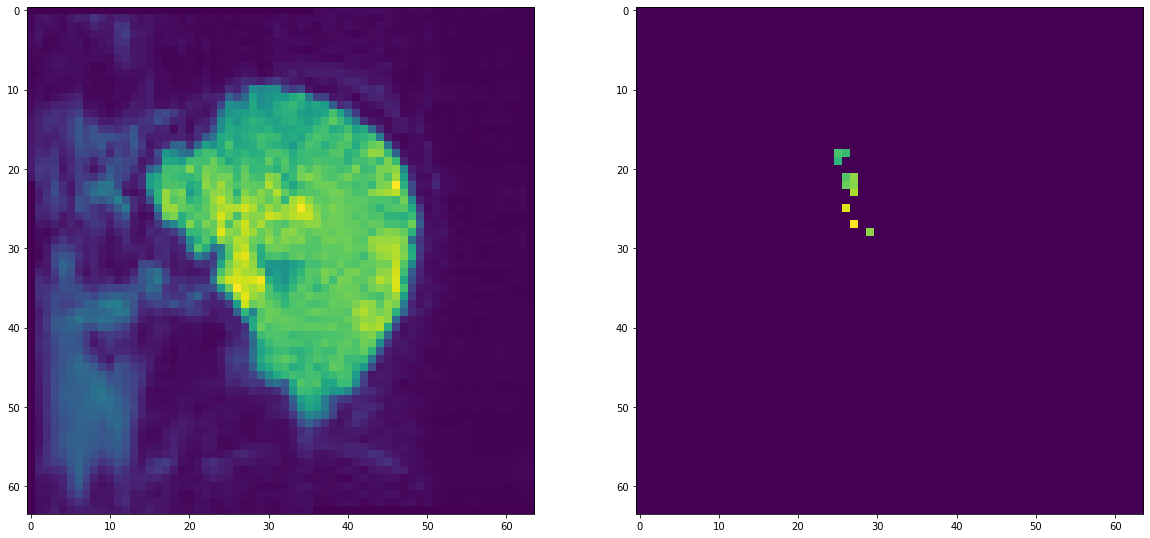

In [ ]:
import os
from mvpa2.suite import *
from matplotlib import pyplot as plt 


# subjpath = os.path.join(pymvpa_datadbroot, 'haxby2001', 'subj1')

print("="*30)
subjpath = os.path.join(os.getcwd(),'datadb', 'haxby2001', 'subj1')
attrs = SampleAttributes(os.path.join(subjpath, 'labels.txt'),
                         header=True)

ds1 = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                  targets=attrs.labels, chunks=attrs.chunks,
                  mask=None)
                  # mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

ds2 = fmri_dataset(samples=os.path.join(subjpath, 'bold.nii.gz'),
                  targets=attrs.labels, chunks=attrs.chunks,
                  # mask=None)
                  mask=os.path.join(subjpath, 'mask4_vt.nii.gz'))

# Sample plots
fig, ax = plt.subplots(1, 2, figsize=(20, 35))
ax[0].imshow(ds1.O[1, 25, :, :])
ax[1].imshow(ds2.O[1, 25, :, :])
fig.show()

## Correlation example

In [ ]:
from mvpa2.measures.corrcoef import pearson_correlation


def normalize(x):
    x = (x - np.min(x))/np.std(x)
    return x


def get_label_dict():
  labels = []
  cats = {}
  with open(os.path.join(subjpath,'labels.txt'), 'r') as f:
      f.readline()
      for i in range(1452):
          s = f.readline().split(' ')
          labels.append((s[0],int(s[1])))
          try:
              cats[s[0]].append(i)
          except:
              cats[s[0]] = [i]
  return labels, cats


def get_corr(cat1, cat2, ds, cats, xx=5, yy=5, maximall_exclude=True, step = 1, maximall_all=True):
  corr = np.zeros([xx, yy])
  for i in range(0,xx*step,step):
    for j in range(0,yy*step,step):
      z = np.mean(ds.O, axis=0).reshape(-1, 1) if maximall_all else np.mean(ds.O[cats[cat1],:,:,:], axis=0).reshape(-1, 1)
      X = ds.O[cats[cat1][i],:,:,:].reshape(-1, 1) - z
      Y = ds.O[cats[cat2][j],:,:,:].reshape(-1, 1) - z

      
      if maximall_exclude:
        z = np.where(z < np.max(z)*0.9)[0]
        X = X[z]
        Y = Y[z]
      
      z = np.union1d( np.where(X > 0)[0], np.where(Y > 0)[0])
      X = normalize(X[z])
      Y = normalize(Y[z])

      corr[int(i/step), int(j/step)] = pearson_correlation(X, Y)
  return corr


def show_colormap_corr(ax, cat1, cat2, ds, xx=5, yy=5, maximall_exclude=True):
  labels, cats = get_label_dict()
  corr = get_corr(cat1=cat1, cat2=cat2, ds=ds, cats=cats, xx=xx, yy=yy, maximall_exclude=maximall_exclude)
  im = ax.imshow(corr, interpolation='None')

  ax.set_title("Correlations between " + cat1 + " and " + cat2)
  ax.set_ylabel(cat1)
  ax.set_xlabel(cat2)
  plt.colorbar(im, ax=ax)
  return


def overall_corr(cat1, cat2, ds, xx=5, yy=5, step=1, maximall_exclude=True, maximall_all=True):
  labels, cats = get_label_dict()
  corr = get_corr(cat1=cat1, cat2=cat2, ds=ds, cats=cats, xx=xx, yy=yy, step=step, maximall_exclude=maximall_exclude, maximall_all=maximall_all)
  return np.mean(corr)

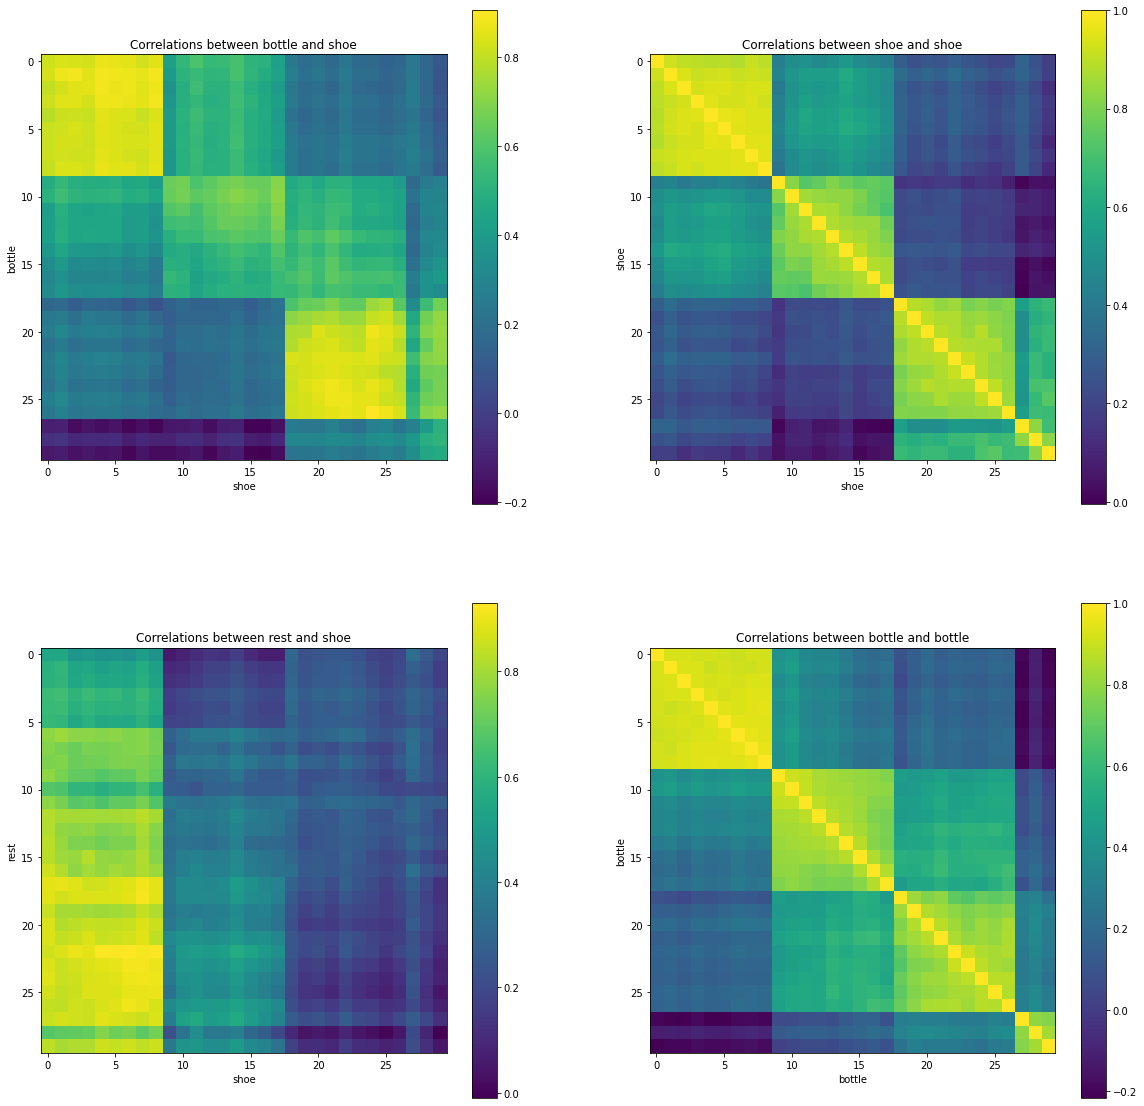

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
x, y = 20, 20

show_colormap_corr(ax=ax[0, 0], cat1="bottle", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[0, 1], cat1="shoe", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 0], cat1="rest", cat2="shoe", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 1], cat1="bottle", cat2="bottle", ds=ds, xx=x, yy=y)

fig.show()

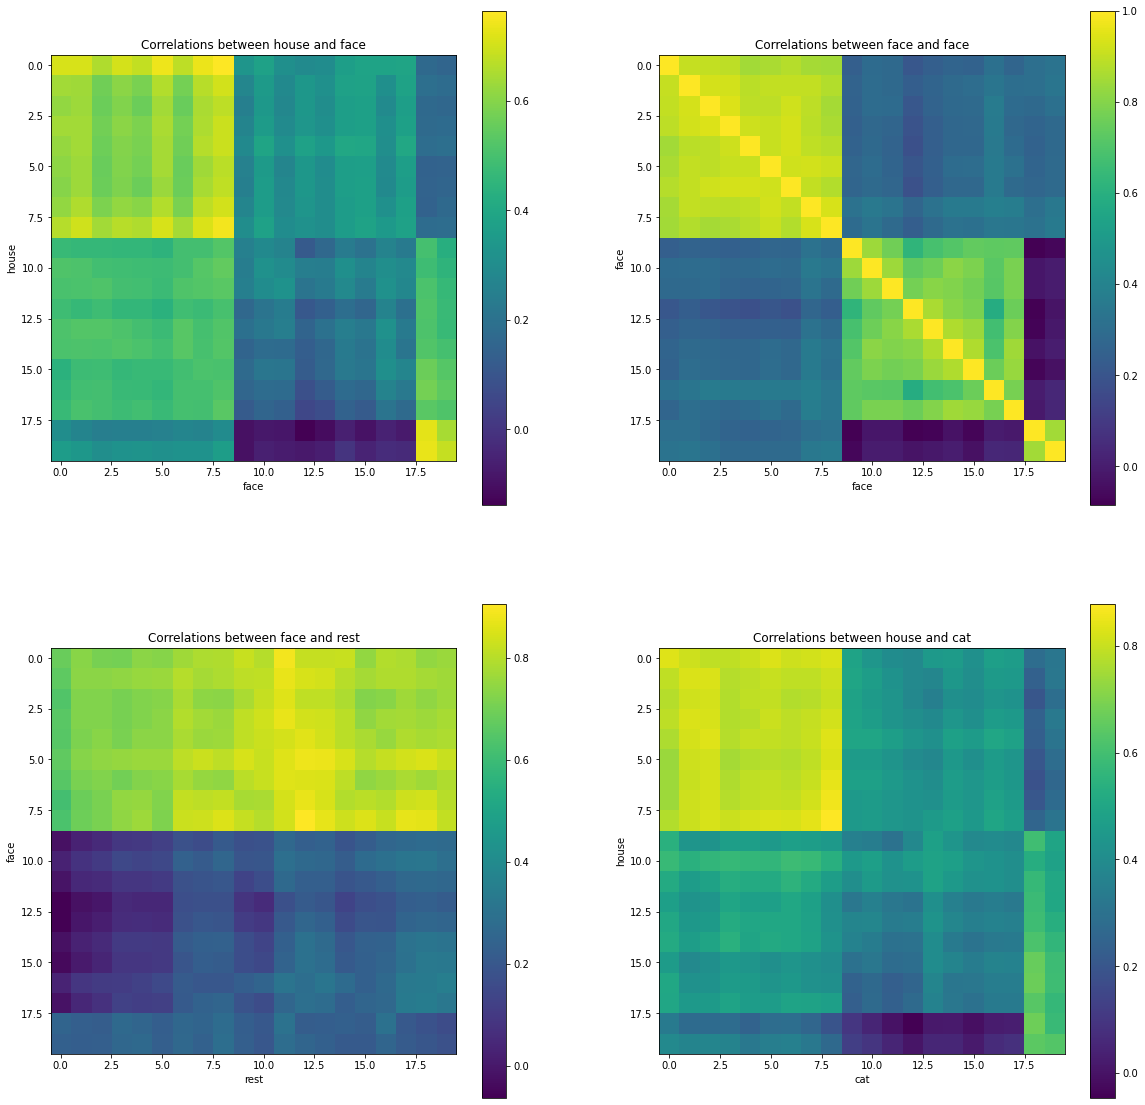

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
x, y = 20, 20

show_colormap_corr(ax=ax[0, 0], cat1="house", cat2="face", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[0, 1], cat1="face", cat2="face", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 0], cat1="face", cat2="rest", ds=ds, xx=x, yy=y)
show_colormap_corr(ax=ax[1, 1], cat1="house", cat2="cat", ds=ds, xx=x, yy=y)

fig.show()

# Distributed and overlapping representation of objects in VTC

In this task, we'll first compute between and within category correlations, then by excluding maximally active voxels (the voxels that are almost active to all or one of stimulis, with an explained activeness factor like mean activity). So if the correlation did not change by this action, it means that information is not concentrated in a specific set of active part of brain and it is distributed; one can say that if the correlation is still significant for different objects active voxels, so it can be concluded that information is also overlapping.

## Correlations between and within categories

In [ ]:
labels, cats = get_label_dict()
cats_labels = list(cats.keys())[1:]

nCat = len(cats_labels)

Corrs = np.zeros([nCat, nCat, 3])

third_dim =  [[True,True], [True,False], [False,False]]
for i in range(nCat):
  for j in range(nCat):
    for k in range(len(third_dim)):
        print("i: {}, j: {}, k: {} --> {:0.2f} %".format(i,j,k, 100*(i*nCat+j+k/3)/(nCat**2)))
        Corrs[i, j, k] = overall_corr(cat1=cats_labels[i], cat2=cats_labels[j], ds=ds, xx=8, yy=8, 
                                           maximall_exclude=third_dim[k][0], maximall_all=third_dim[k][1], step=2)


done()

i: 0, j: 0, k: 0 --> 0.00 %
i: 0, j: 0, k: 1 --> 0.52 %
i: 0, j: 0, k: 2 --> 1.04 %
i: 0, j: 1, k: 0 --> 1.56 %
i: 0, j: 1, k: 1 --> 2.08 %
i: 0, j: 1, k: 2 --> 2.60 %
i: 0, j: 2, k: 0 --> 3.12 %
i: 0, j: 2, k: 1 --> 3.65 %
i: 0, j: 2, k: 2 --> 4.17 %
i: 0, j: 3, k: 0 --> 4.69 %
i: 0, j: 3, k: 1 --> 5.21 %
i: 0, j: 3, k: 2 --> 5.73 %
i: 0, j: 4, k: 0 --> 6.25 %
i: 0, j: 4, k: 1 --> 6.77 %
i: 0, j: 4, k: 2 --> 7.29 %
i: 0, j: 5, k: 0 --> 7.81 %
i: 0, j: 5, k: 1 --> 8.33 %
i: 0, j: 5, k: 2 --> 8.85 %
i: 0, j: 6, k: 0 --> 9.38 %
i: 0, j: 6, k: 1 --> 9.90 %
i: 0, j: 6, k: 2 --> 10.42 %
i: 0, j: 7, k: 0 --> 10.94 %
i: 0, j: 7, k: 1 --> 11.46 %
i: 0, j: 7, k: 2 --> 11.98 %
i: 1, j: 0, k: 0 --> 12.50 %
i: 1, j: 0, k: 1 --> 13.02 %
i: 1, j: 0, k: 2 --> 13.54 %
i: 1, j: 1, k: 0 --> 14.06 %
i: 1, j: 1, k: 1 --> 14.58 %
i: 1, j: 1, k: 2 --> 15.10 %
i: 1, j: 2, k: 0 --> 15.62 %
i: 1, j: 2, k: 1 --> 16.15 %
i: 1, j: 2, k: 2 --> 16.67 %
i: 1, j: 3, k: 0 --> 17.19 %
i: 1, j: 3, k: 1 --> 17.71 %
i: 1,

KeyboardInterrupt: ignored

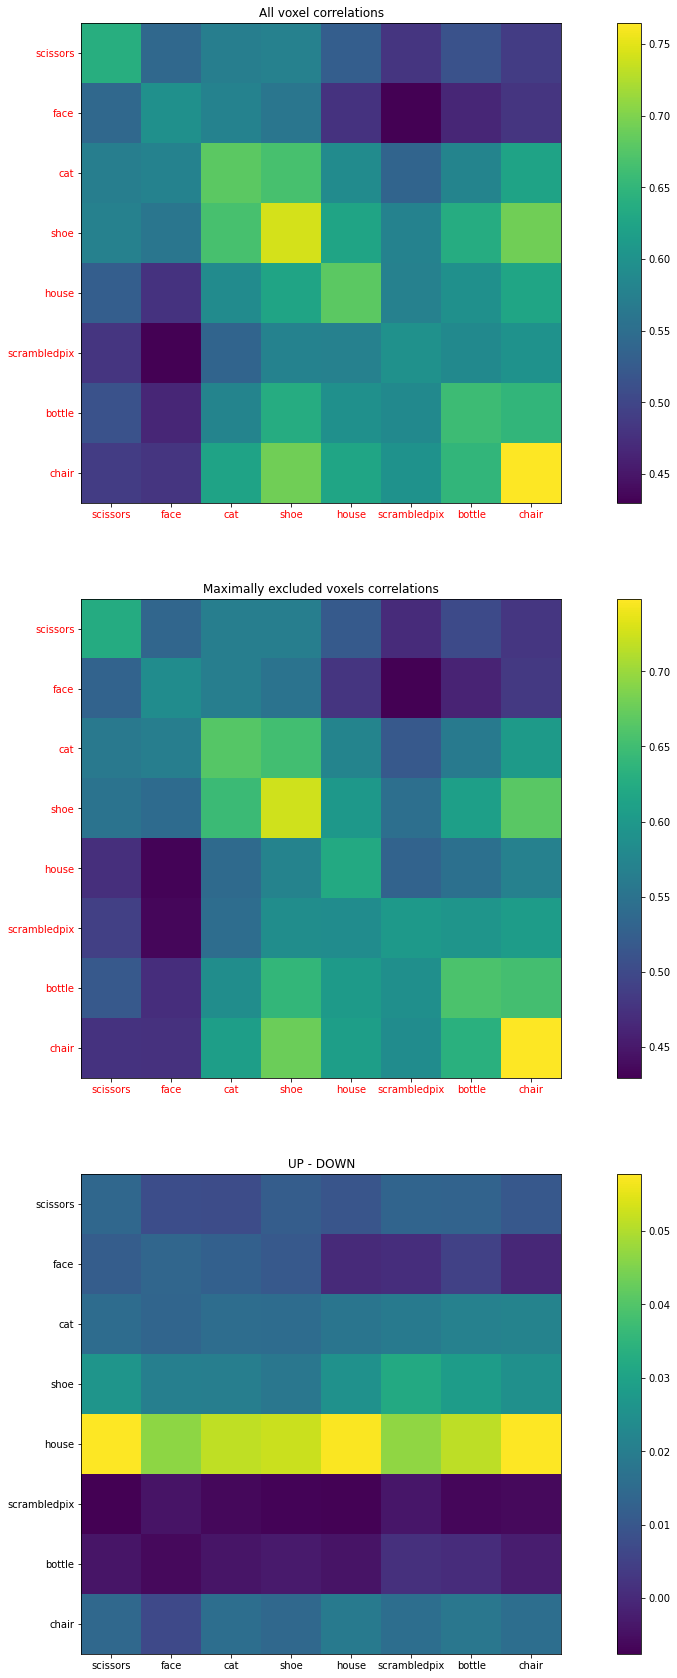

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 30))
title_labels = ["All voxel correlations","Maximally excluded voxels correlations","UP - DOWN"]

for i in range(len(title_labels)):
  im = None
  if i < 2 :
    im = ax[i].imshow(Corrs[:, :, i], interpolation='None')
  else:
    im = ax[i].imshow(Corrs[:, :, 0] - Corrs[:, :, 1] , interpolation='None')
  ax[i].set_title(title_labels[i])
  ax[i].set_xticks(list(range(nCat))); ax[i].set_xticklabels(cats_labels)
  ax[i].set_yticks(list(range(nCat))); ax[i].set_yticklabels(cats_labels)
  plt.colorbar(im, ax=ax[i])

for i in range(2):
  for xtick,ytick in zip(ax[i].get_xticklabels(), ax[i].get_yticklabels()):
    xtick.set_color('red')
    ytick.set_color('red')

fig.show()

# Hyperalignment and common model

http://www.pymvpa.org/examples/hyperalignment.html

In [ ]:
from mvpa2.suite import *

# filepath = wget.download('http://data.pymvpa.org/datasets/hyperalignment_tutorial_data/hyperalignment_tutorial_data.hdf5.gz')
filepath = wget.download('http://data.pymvpa.org/datasets/hyperalignment_tutorial_data/hyperalignment_tutorial_data_2.4.hdf5.gz')

# extract_tarfile(fname=filepath, path="")

verbose.level = 2
verbose(1, "Loading data...")
# filepath = os.path.join(cfg.get('location', 'tutorial data'), "hyperalignment_tutorial_data.hdf5.gz")
# ds_all = h5load(filepath)
ds_all = h5load(filepath)
# zscore all datasets individually
_ = [zscore(ds) for ds in ds_all]
# inject the subject ID into all datasets
for i, sd in enumerate(ds_all):
    sd.sa['subject'] = np.repeat(i, len(sd))
# number of subjects
nsubjs = len(ds_all)
# number of categories
ncats = len(ds_all[0].UT)
# number of run
nruns = len(ds_all[0].UC)
verbose(2, "%d subjects" % len(ds_all))
verbose(2, "Per-subject dataset: %i samples with %i features" % ds_all[0].shape)
verbose(2, "Stimulus categories: %s" % ', '.join(ds_all[0].UT))

## Anatomical aligned data classification



In [ ]:
verbose(2, "between-subject (anatomically aligned)...", cr=False, lf=False)
ds_mni = vstack(ds_all)
mni_start_time = time.time()
cv = CrossValidation(fsclf,
                     NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)
bsc_mni_results = cv(ds_mni)
verbose(2, "done in %.1f seconds" % (time.time() - mni_start_time,))

## Hyperaligned data classification

In [ ]:
verbose(2, "between-subject (hyperaligned)...", cr=False, lf=False)
hyper_start_time = time.time()
bsc_hyper_results = []
# same cross-validation over subjects as before
cv = CrossValidation(clf, NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)

# leave-one-run-out for hyperalignment training
for test_run in range(nruns):
    # split in training and testing set
    ds_train = [sd[sd.sa.chunks != test_run, :] for sd in ds_all]
    ds_test = [sd[sd.sa.chunks == test_run, :] for sd in ds_all]

    # manual feature selection for every individual dataset in the list
    anova = OneWayAnova()
    fscores = [anova(sd) for sd in ds_train]
    featsels = [StaticFeatureSelection(fselector(fscore)) for fscore in fscores]
    ds_train_fs = [fs.forward(sd) for fs, sd in zip(featsels, ds_train)]


    # Perform hyperalignment on the training data with default parameters.
    # Computing hyperalignment parameters is as simple as calling the
    # hyperalignment object with a list of datasets. All datasets must have the
    # same number of samples and time-locked responses are assumed.
    # Hyperalignment returns a list of mappers corresponding to subjects in the
    # same order as the list of datasets we passed in.


    hyper = Hyperalignment()
    hypmaps = hyper(ds_train_fs)

    # Applying hyperalignment parameters is similar to applying any mapper in
    # PyMVPA. We start by selecting the voxels that we used to derive the
    # hyperalignment parameters. And then apply the hyperalignment parameters
    # by running the test dataset through the forward() function of the mapper.

    ds_test_fs = [fs.forward(sd) for fs, sd in zip(featsels, ds_test)]
    ds_hyper = [h.forward(sd) for h, sd in zip(hypmaps, ds_test_fs)]

    # Now, we have a list of datasets with feature correspondence in a common
    # space derived from the training data. Just as in the between-subject
    # analyses of anatomically aligned data we can stack them all up and run the
    # crossvalidation analysis.

    ds_hyper = vstack(ds_hyper)
    # zscore each subject individually after transformation for optimal
    # performance
    zscore(ds_hyper, chunks_attr='subject')
    res_cv = cv(ds_hyper)
    bsc_hyper_results.append(res_cv)

bsc_hyper_results = hstack(bsc_hyper_results)
verbose(2, "done in %.1f seconds" % (time.time() - hyper_start_time,))

## Principal component analysis (PCA) and classification quality

# End